Processing: HL2_20250317_145308.wav


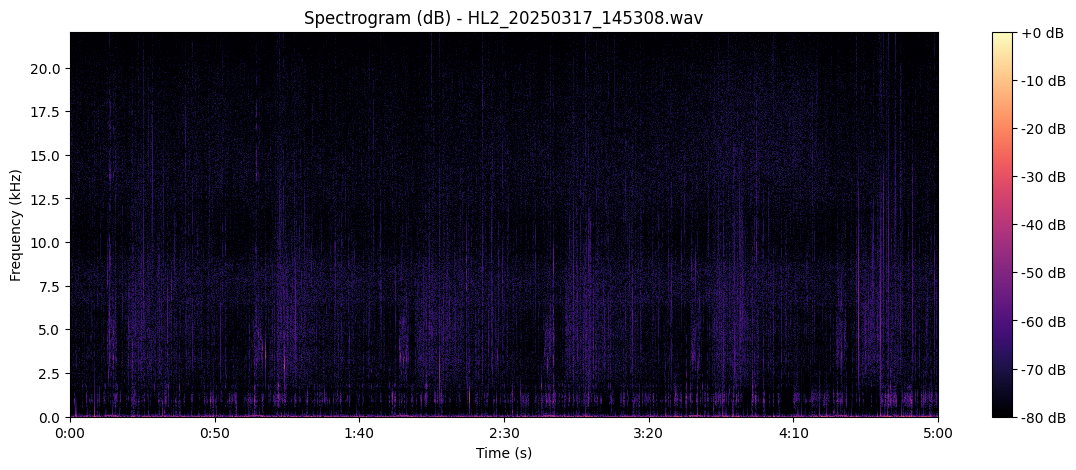

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def plot_spectrogram(audio_path):
    """
    Plot the spectrogram of an audio file without log scale and with frequency in kHz.
    """
    print(f"Processing: {audio_path}")
    
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Compute the Short-Time Fourier Transform (STFT) and convert to dB
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')  # Use linear scale
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram (dB) - {audio_path}')
    
    # Customize y-axis to display in kHz
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1000:.1f}'))
    plt.ylabel('Frequency (kHz)')
    plt.xlabel('Time (s)')
    plt.show()

# Example usage
if __name__ == "__main__":
    audio_file = "HL2_20250317_145308.wav"  # Replace with the actual file path
    plot_spectrogram(audio_file)

Processing: HL2_20250317_145308.wav


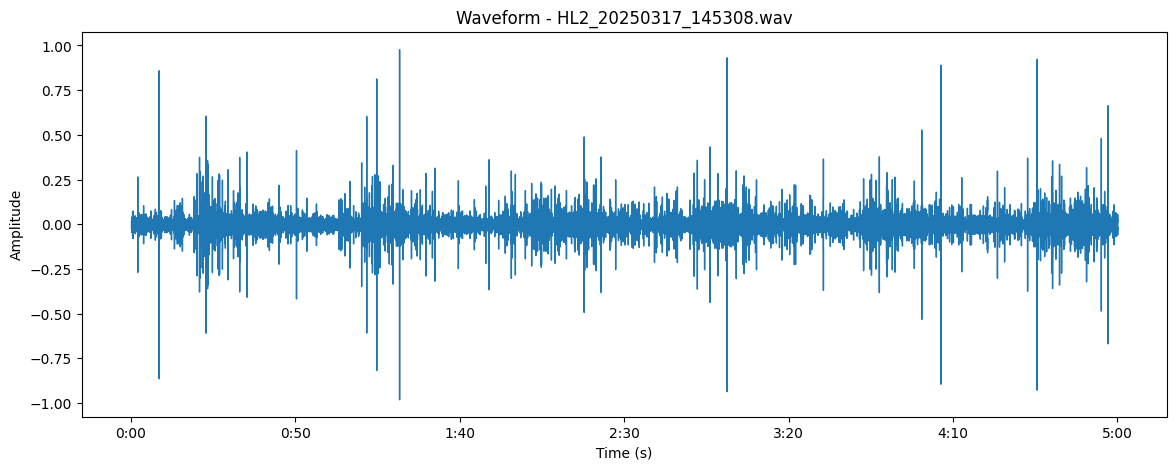

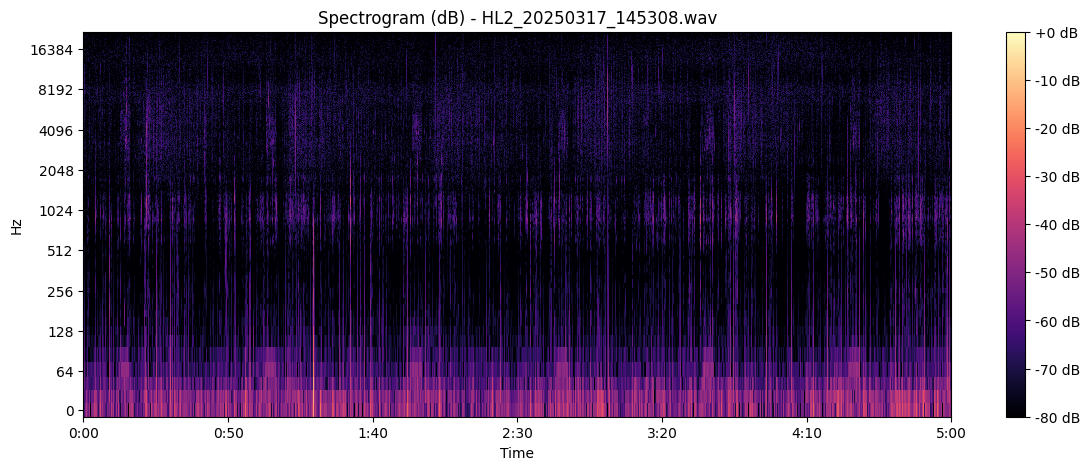

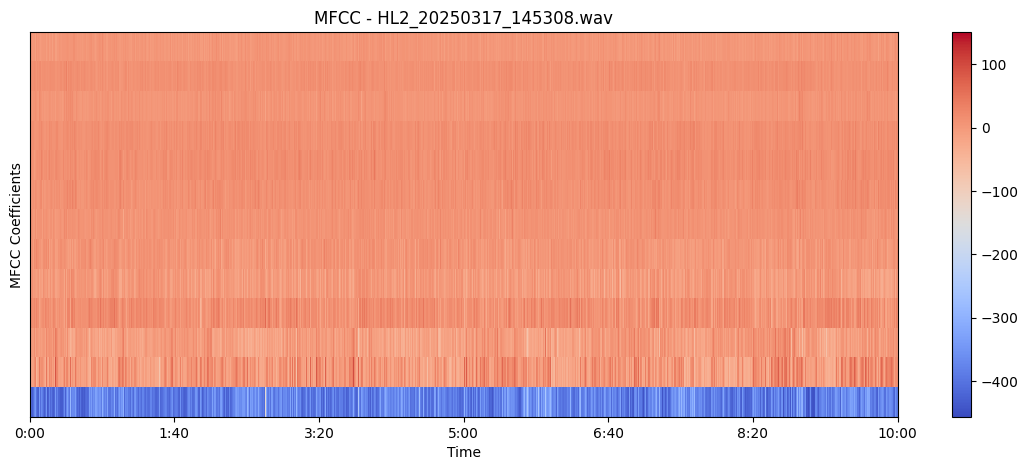

MFCCs saved to HL2_20250317_145308.wav_mfcc_features.csv


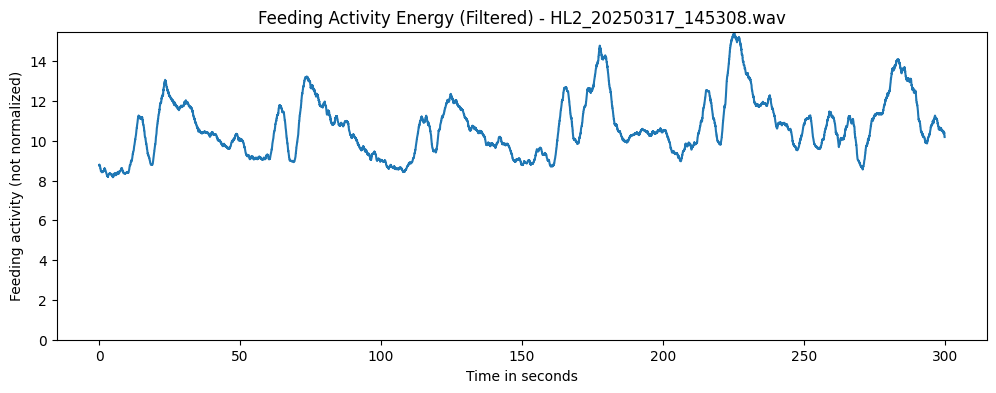

Feeding activity data saved to HL2_20250317_145308.wav_feeding_activity_energy.csv


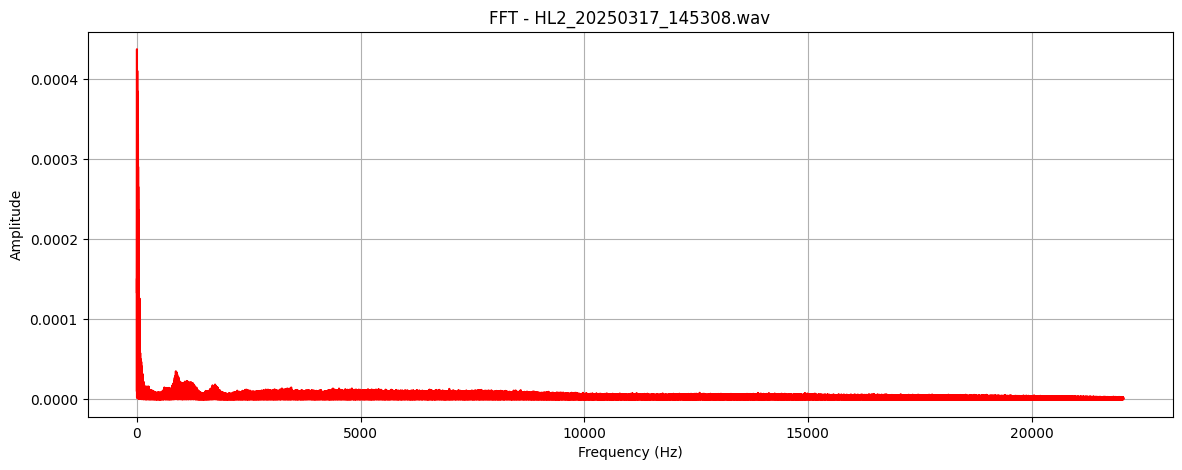

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
from scipy.fftpack import fft
from scipy.ndimage import median_filter

def process_audio_file(audio_path):
    """
    Process a single audio file to plot waveform, spectrogram, MFCC, energy, and FFT.
    """
    print(f"Processing: {audio_path}")
    
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # 1. Plot waveform
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {audio_path}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # 2. Plot spectrogram (Short-Time Fourier Transform)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram (dB) - {audio_path}')
    plt.show()

    # 3. Extract and plot MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC - {audio_path}')
    plt.ylabel('MFCC Coefficients')
    plt.show()

    # Optional: Save the MFCCs for further analysis
    mfcc_filename = f"{audio_path}_mfcc_features.csv"
    np.savetxt(mfcc_filename, mfccs, delimiter=',')
    print(f"MFCCs saved to {mfcc_filename}")

    # 4. Analyze energy across all frequencies (feeding activity)

    # Parameters for energy calculation
    win_length = int(sr / 1000 * 10)  # 10 ms window length
    hop_length = int(win_length // 2 + 1)
    n_fft = int(2 ** np.ceil(np.log2(win_length)))

    # Compute the Short-Time Fourier Transform (STFT)
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

    # Frequency bins (in Hz)
    f = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    t = librosa.frames_to_time(np.arange(0, S.shape[1]), sr=sr, hop_length=hop_length)

    # Compute energy across all frequencies (sum across frequency bins)
    frame_wise_energy = np.sum(np.abs(S), axis=0)

    # Apply median filtering for smoother energy calculation
    medfilt_size = 997
    frame_wise_energy = median_filter(frame_wise_energy, size=medfilt_size)

    # Plot the filtered energy
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(t, frame_wise_energy)
    ax.set_ylim(0, np.max(frame_wise_energy))  # Dynamically adjust y-axis
    ax.set_xlabel('Time in seconds')
    ax.set_ylabel('Feeding activity (not normalized)')
    plt.title(f'Feeding Activity Energy (Filtered) - {audio_path}')
    plt.show()

    # Save the energy data for further analysis
    energy_filename = f"{audio_path}_feeding_activity_energy.csv"
    df = pd.DataFrame({'time': t, 'energy': frame_wise_energy})
    df.to_csv(energy_filename, index=False)
    print(f"Feeding activity data saved to {energy_filename}")

    # 5. Compute and plot FFT
    N = len(y)
    yf = fft(y)
    xf = np.linspace(0.0, sr / 2.0, N // 2)

    plt.figure(figsize=(14, 5))
    plt.plot(xf, 2.0 / N * np.abs(yf[:N // 2]), color="red")
    plt.title(f'FFT - {audio_path}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

def process_multiple_audio_files(audio_files):
    """
    Process multiple audio files.
    """
    for audio_path in audio_files:
        process_audio_file(audio_path)


# Example usage
if __name__ == "__main__":
    # Replace with paths to your 3 audio files
    audio_files = [
        "HL2_20250317_145308.wav",  # Replace with the actual file paths
    ]
    process_multiple_audio_files(audio_files)

In [6]:
import gc
gc.collect()

26398

Audio duration: 300.00 seconds
Sampling rate: 44100 Hz


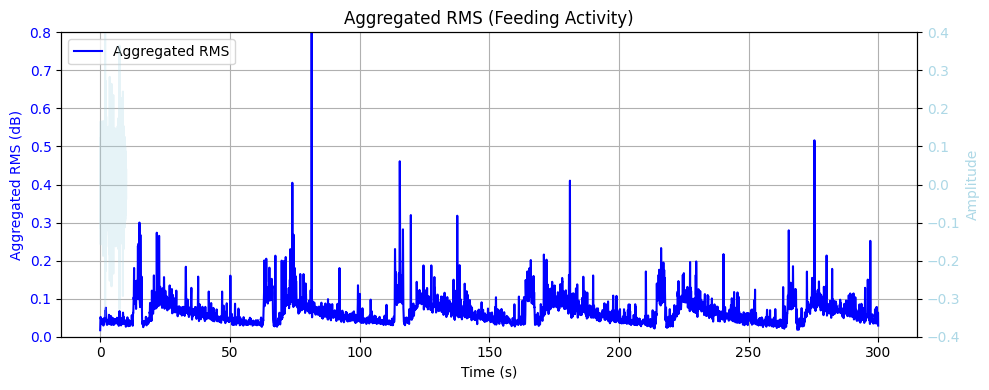

In [11]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt

# Step 1: Load the audio file
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

# Step 2: Apply a bandpass filter (2000–6000 Hz)
def bandpass_filter(audio, sr, lowcut=2000, highcut=6000):
    # Design a Butterworth bandpass filter
    sos = butter(10, [lowcut, highcut], btype='band', fs=sr, output='sos')
    # Apply the filter
    filtered_audio = sosfiltfilt(sos, audio)
    return filtered_audio

# Step 3: Compute RMS energy over time with smoothing
def compute_rms(audio, sr, frame_length=4096, hop_length=1024):
    # Compute RMS energy for each frame
    rms = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]
    # Smooth the RMS to reduce noise (using a simple moving average)
    window_size = 5
    rms = np.convolve(rms, np.ones(window_size)/window_size, mode='same')
    # Normalize RMS to the range 0 to 0.8
    max_rms = np.max(rms)
    if max_rms > 0:  # Avoid division by zero
        rms = rms * (0.8 / max_rms)
    # Convert frame indices to time
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)
    return rms, times

# Step 4: Plot the RMS and zoomed-in filtered waveform
def plot_rms_feeding_activity(filtered_audio, sr, audio_duration):
    # Compute RMS
    rms, rms_times = compute_rms(filtered_audio, sr)
    
    # Create the plot with a wider figure
    plt.figure(figsize=(10, 4))  # Increased width from 7.5 to 10
    
    # Plot RMS (left y-axis)
    ax1 = plt.gca()
    ax1.plot(rms_times, rms, color='blue', label='Aggregated RMS')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Aggregated RMS (dB)', color='blue')
    ax1.set_ylim(0, 0.8)  # Set y-axis limits to match the source plot
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)
    ax1.set_title('Aggregated RMS (Feeding Activity)')
    ax1.legend(loc='upper left')
    
    # Plot zoomed-in filtered waveform (right y-axis)
    ax2 = ax1.twinx()
    times = np.arange(len(filtered_audio)) / sr
    zoom_samples = int(10 * sr)  # First 10 seconds
    zoom_samples = min(zoom_samples, len(filtered_audio))
    zoom_times = times[:zoom_samples]
    zoom_audio = filtered_audio[:zoom_samples]
    # Normalize the zoomed audio to the range -0.4 to 0.4
    max_amplitude = np.max(np.abs(zoom_audio))
    if max_amplitude > 0:
        zoom_audio = zoom_audio * (0.4 / max_amplitude)
    ax2.plot(zoom_times, zoom_audio, color='lightblue', alpha=0.3)
    ax2.set_ylabel('Amplitude', color='lightblue')
    ax2.set_ylim(-0.4, 0.4)  # Set y-axis limits to match the source plot
    ax2.tick_params(axis='y', labelcolor='lightblue')
    
    plt.tight_layout()
    plt.show()

# Main function
def analyze_rms(file_path):
    # Load audio
    audio, sr = load_audio(file_path)
    audio_duration = len(audio) / sr
    print(f"Audio duration: {audio_duration:.2f} seconds")
    print(f"Sampling rate: {sr} Hz")
    
    # Apply bandpass filter (2000–6000 Hz)
    filtered_audio = bandpass_filter(audio, sr, lowcut=2000, highcut=6000)
    
    # Plot RMS and zoomed-in filtered waveform
    plot_rms_feeding_activity(filtered_audio, sr, audio_duration)

# Example usage
if __name__ == "__main__":
    file_path = "HL2_20250317_145308.wav"  # Update with your actual file path
    try:
        analyze_rms(file_path)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found. Please provide a valid audio file path.")

Audio duration: 300.00 seconds
Sampling rate: 44100 Hz

CPS Values Over Time:
Time (s)	CPS
0.50		7.40
1.50		9.40
2.50		11.40
3.50		12.00
4.50		11.40
5.50		10.40
6.50		11.40
7.50		11.20
8.50		10.20
9.50		9.80
10.50		9.80
11.50		14.20
12.50		21.20
13.50		27.40
14.50		27.40
15.50		27.40
16.50		22.00
17.50		16.80
18.50		16.60
19.50		23.60
20.50		30.20
21.50		39.20
22.50		43.40
23.50		45.40
24.50		46.20
25.50		45.00
26.50		42.20
27.50		41.20
28.50		39.40
29.50		35.80
30.50		33.80
31.50		32.00
32.50		30.00
33.50		28.00
34.50		29.00
35.50		29.00
36.50		27.20
37.50		27.60
38.50		25.40
39.50		23.20
40.50		22.40
41.50		21.20
42.50		20.40
43.50		20.00
44.50		18.00
45.50		15.60
46.50		15.40
47.50		13.80
48.50		13.40
49.50		13.20
50.50		12.40
51.50		11.60
52.50		11.00
53.50		10.60
54.50		9.00
55.50		8.80
56.50		8.60
57.50		7.60
58.50		6.60
59.50		6.80
60.50		7.00
61.50		12.20
62.50		20.40
63.50		26.80
64.50		30.80
65.50		30.00
66.50		23.80
67.50		17.80
68.50		15.60
69.50		19.00
70.50		26.60
71.50		

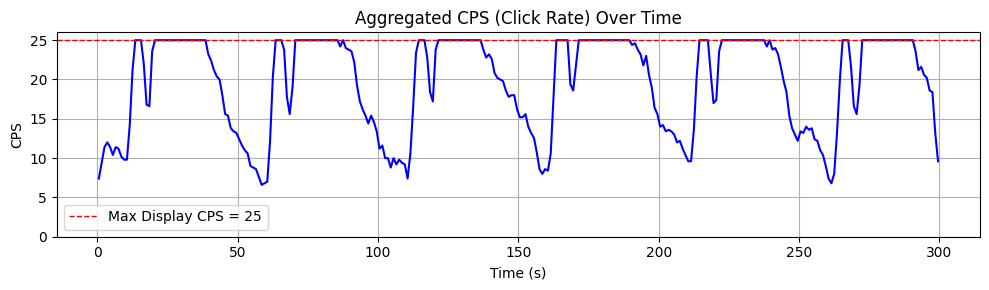

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, sosfiltfilt

# Configuration Parameters
SAMPLE_RATE = 44100
PEAK_HEIGHT = 0.01  # Minimum amplitude for a shrimp click
PEAK_DISTANCE = int(SAMPLE_RATE / 100)  # ~10ms at 44100 Hz
MAX_CPS_DISPLAY = 25

# Step 1: Load the audio file
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    return audio, sr

# Step 2: Apply a bandpass filter (2000–6000 Hz)
def bandpass_filter(audio, sr, lowcut=2000, highcut=6000):
    sos = butter(10, [lowcut, highcut], btype='band', fs=sr, output='sos')
    filtered_audio = sosfiltfilt(sos, audio)
    return filtered_audio

# Step 3: Detect clicks and calculate CPS in each frame
def calculate_cps(audio, sr, frame_duration=1.0, threshold_energy=PEAK_HEIGHT, min_distance=PEAK_DISTANCE):
    # Number of samples per frame
    frame_samples = int(frame_duration * sr)
    hop_samples = frame_samples  # Non-overlapping frames
    num_frames = len(audio) // hop_samples
    
    # Initialize arrays
    cps = []
    frame_times = []
    
    # Process each frame
    for i in range(num_frames):
        start = i * hop_samples
        end = start + frame_samples
        frame = audio[start:end]
        
        # Detect peaks in the frame
        peaks, _ = find_peaks(np.abs(frame), height=threshold_energy, distance=min_distance)
        
        # Calculate CPS for this frame
        clicks_in_frame = len(peaks)
        cps_value = clicks_in_frame / frame_duration
        cps.append(cps_value)
        
        # Time at the center of the frame
        frame_times.append((start + end) / (2 * sr))
    
    # Smooth the CPS values to reduce noise
    cps = np.array(cps)
    window_size = 5
    cps = np.convolve(cps, np.ones(window_size)/window_size, mode='same')
    
    return cps, np.array(frame_times)

# Step 4: Plot the CPS over time
def plot_aggregated_cps(time_axis, cps_values, audio_duration, max_cps=MAX_CPS_DISPLAY):
    # Truncate any values above max_cps
    cps_truncated = np.clip(cps_values, 0, max_cps)
    
    # Create the plot
    plt.figure(figsize=(10, 3))
    plt.plot(time_axis, cps_truncated, linestyle='-', color='blue')
    plt.axhline(max_cps, color='red', linestyle='--', linewidth=1, label=f"Max Display CPS = {max_cps}")
    
    plt.title("Aggregated CPS (Click Rate) Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("CPS")
    plt.ylim(0, max_cps + 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main function
def analyze_cps(file_path):
    # Load audio
    audio, sr = load_audio(file_path)
    audio_duration = len(audio) / sr
    print(f"Audio duration: {audio_duration:.2f} seconds")
    print(f"Sampling rate: {sr} Hz")
    
    # Apply bandpass filter (2000–6000 Hz)
    filtered_audio = bandpass_filter(audio, sr, lowcut=2000, highcut=6000)
    
    # Calculate CPS
    cps, frame_times = calculate_cps(filtered_audio, sr, frame_duration=1.0)
    
    # Print CPS values
    print("\nCPS Values Over Time:")
    print("Time (s)\tCPS")
    for t, c in zip(frame_times, cps):
        print(f"{t:.2f}\t\t{c:.2f}")
    
    # Print some basic statistics
    print("\nCPS Statistics:")
    print(f"Average CPS: {np.mean(cps):.2f}")
    print(f"Maximum CPS: {np.max(cps):.2f}")
    print(f"Minimum CPS: {np.min(cps):.2f}")
    print(f"Number of frames with CPS >= 5: {np.sum(cps >= 5)}")
    print(f"Number of frames with CPS >= 10: {np.sum(cps >= 10)}")
    
    # Plot CPS
    plot_aggregated_cps(frame_times, cps, audio_duration)

# Example usage
if __name__ == "__main__":
    file_path = "HL2_20250317_145308.wav"  # Update with your actual file path
    try:
        analyze_cps(file_path)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found. Please provide a valid audio file path.")